In [30]:
import numpy as np
import control as ct
from matplotlib import pyplot as plt
from Kalman import KalmanFilter, System

In [31]:
def plot_step(sys, title='', idx=0, T=None, show=False, fig=None):
    if fig is None:
        fig = plt.figure()
    fig.suptitle(title)
    ax=fig.gca()
    T, yout, x = ct.step_response(sys, T=T, return_x=True)  # ct.step_response // matlab interop "step"
    if idx != 0:
        y = x[idx,:]
    else:
        y=yout
    ax.plot(T.T, y)
    if show:
        plt.show(block=False)
    
    return T, fig

def biquad_tf(f0, bw, a):
    b0 = 1
    b1 = a*bw*2*np.pi
    b2 = (f0*2*np.pi)**2
    a0 = 1
    a1 = bw*2*np.pi
    a2 = (f0*2*np.pi)**2

    # Create transfer function using tf()
    numerator = [b0, b1, b2]
    # numerator = [1]
    denominator = [a0, a1, a2]
    H = ct.tf(numerator, denominator)

    return H

In [32]:
# mass of load, kg
M2 = 0.8
# friction for load
b2 = 0.1
# spring rate of belt, guess 10 N stretches 0.5mm, N/m - gates says 18000 lb/in/in for 1" wide belt, some paper says 55N/mm
# Ks = 10/.0005
Ks = 45000
print(f'Belt Stiffness: {Ks} N/m')
#friction internal to belt
b3 = 1
# radius of belt pulley, m
r = 0.005
# inertia of motor
J = 5e-5
# friction in motor
b1 = 2e-4
# motor constant
Km = 0.041
# phase resistance
R = 5.6
# phase inductance
L = 0.0045

dt = 0.00001
T_sim = np.arange(0, 10,dt)

fbed = np.sqrt(Ks/M2)/(2*np.pi)
print(fbed)

fmotor = np.sqrt(Ks*r/J)/(2*np.pi)
print(fmotor)
print((1/fmotor)/np.pi)

Belt Stiffness: 45000 N/m
37.74690907836528
337.61861855891476
0.0009428090415820635


In [33]:
# A = np.array([[0,       1,      0.5*dt, 0,          0,      0,      0],
#               [0,       0,      1,      0,          0,      0,      0],
#               [-Ks/M2,  -b2/M2, 0,      Ks*r/M2,    0,      0,      0],
#               [0,       0,      0,      0,          1,      0.5*dt, 0],
#               [0,       0,      0,      0,          0,      1,      0],
#               [Ks*r/J,  0,      0,      -Ks*r*r/J,  -b1/J,  0,      Km/J],
#               [0,       0,      0,      0,          -Km/L,  0,      -R/L]])
# A = np.array([[0,       1,      0,          0,      0],
#               [-Ks/M2,  -b2/M2, Ks*r/M2,    0,      0],
#               [0,       0,      0,          1,      0],
#               [Ks*r/J,  0,      -Ks*r*r/J,  -b1/J,  Km/J],
#               [0,       0,      0,          -Km/L,  -R/L]])

A = np.array([[0,       1,              0,          0],
              [-Ks/M2,  -(b2+b3)/M2,    Ks*r/M2,    (b3*r)/M2],
              [0,       0,              0,          1],
              [Ks*r/J,  (b3*r)/J,       -Ks*r**2/J,  (-b1-b3*r**2)/J]])
# A = np.eye(A.shape[0]) + A*dt

B = np.array([[0, 0, 0, Km/J]]).T
# B = B*dt

C = np.array([[0, 0, 1, 0]])  # motor position feedback only

print(np.eye(A.shape[0])+A*dt)

[[ 1.0000000e+00  1.0000000e-05  0.0000000e+00  0.0000000e+00]
 [-5.6250000e-01  9.9998625e-01  2.8125000e-03  6.2500000e-08]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00  1.0000000e-05]
 [ 4.5000000e+01  1.0000000e-03 -2.2500000e-01  9.9995500e-01]]


In [34]:
sys = ct.ss(A, B, C, 0)
print(sys)

controllability = ct.ctrb(A, B)

print('The controllability matrix is:\n')
print(controllability )
if np.linalg.matrix_rank(controllability) == np.array(B).shape[0]:
    print('\nThe system is controllable!')
else:
    print('\nThe system is not controllable, double-check your modelling and that you entered the system matrices correctly')

observability = ct.obsv(A, C)

print('\nThe observability matrix is:\n')
print(observability)

if np.linalg.matrix_rank(observability) == sys.nstates:
    print('\nThe system is observable!')
else:
    print('\nThe system is not observable, double-check your modelling and that you entered the matrices correctly')



<LinearIOSystem>: sys[40]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.0000e+00  1.0000e+00  0.0000e+00  0.0000e+00]
     [-5.6250e+04 -1.3750e+00  2.8125e+02  6.2500e-03]
     [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]
     [ 4.5000e+06  1.0000e+02 -2.2500e+04 -4.5000e+00]]

B = [[  0.]
     [  0.]
     [  0.]
     [820.]]

C = [[0. 0. 1. 0.]]

D = [[0.]]

The controllability matrix is:

[[ 0.00000000e+00  0.00000000e+00  5.12500000e+00  2.30594891e+05]
 [ 0.00000000e+00  5.12500000e+00  2.30594891e+05 -1.75836724e+06]
 [ 0.00000000e+00  8.20000000e+02 -3.69000000e+03 -1.84328825e+07]
 [ 8.20000000e+02 -3.69000000e+03 -1.84328825e+07  2.12094960e+08]]

The system is controllable!

The observability matrix is:

[[ 0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]
 [ 4.5000000e+06  1.0000000e+02 -2.2500000e+04 -4.5000000e+00]
 [-2.5875000e+07  4.4994125e+0

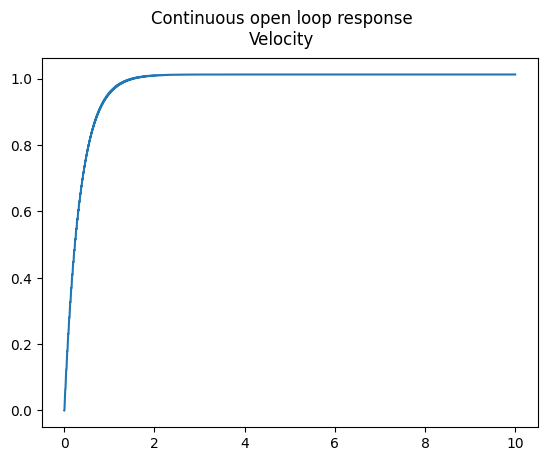

In [35]:
_, fig = plot_step(sys, 'Continuous open loop response\nVelocity', T=T_sim, idx=1, show=False)
# T, yout = ct.step_response(sys)  # ct.step_response
# plt.plot(T.T, yout.T*31/6.28)
plt.show()


The poles of the open loop system are:

[-1.49101514e+00+280.6148828j -1.49101514e+00-280.6148828j
 -2.89296972e+00  +0.j        -1.78603350e-12  +0.j       ]


(inf, 6.832218844347949, nan, 24.079650550185885)

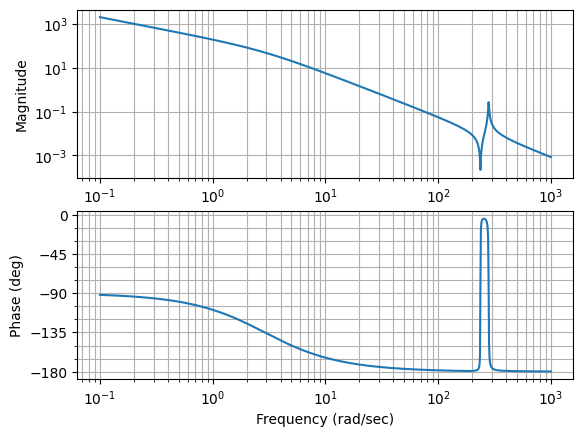

In [36]:
ct.bode_plot(sys)
closed_loop_poles = ct.pole(sys)
print('\nThe poles of the open loop system are:\n')
print(closed_loop_poles)
ct.margin(sys)

The control gain is:

K =  [[-1.79879071e+04  1.89061611e+00  9.64459810e+01  3.19377665e+00
   1.00000000e+03]]

The poles of the closed loop system are:

[-2.58444063e+03  +0.j         -1.91502862e+01+238.26919729j
 -1.91502862e+01-238.26919729j -1.01532678e+00  +0.72859283j
 -1.01532678e+00  -0.72859283j  0.00000000e+00  +0.j
  0.00000000e+00  +0.j          0.00000000e+00  +0.j
  0.00000000e+00  +0.j          0.00000000e+00  +0.j        ]
<LinearICSystem>: sys[45]
Inputs (1): ['u[0]']
Outputs (5): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]']
States (10): ['sys[43]_x[0]', 'sys[43]_x[1]', 'sys[43]_x[2]', 'sys[43]_x[3]', 'sys[43]_x[4]', 'sys[44]_x[0]', 'sys[44]_x[1]', 'sys[44]_x[2]', 'sys[44]_x[3]', 'sys[44]_x[4]']

A = [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
       0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
       0.00000000e+00  0.00000000e+00]
     [-5.62500000e+04 -1.37500000e+00  2.81250000e+02  6.25000000e-03
       0.00000000e+00  0.0000

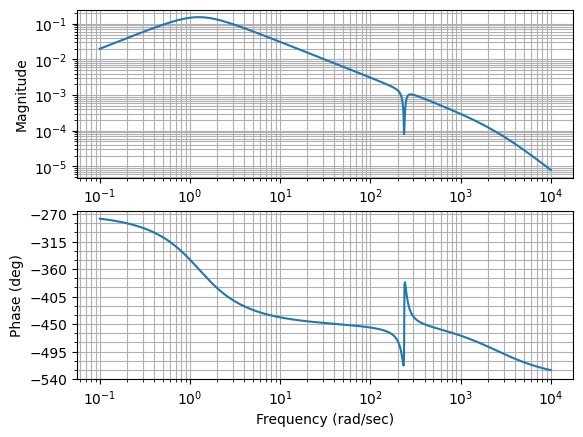

In [37]:
# quadratic cost function
Q_ctrl = np.array([ [100,    0,      0,      0, 0],
                    [0,    100,      0,      0, 0],
                    [0,     0,      0.1,      0, 0],
                    [0,     0,      0,      0.1, 0],
                    [0,     0,      0,      0, 10000]])
R_ctrl = np.array([ [0.01] ])

Ai = np.concatenate((A,np.array([[1,0,0,0]])),axis=0)
Ai = np.concatenate((Ai,np.array([[0,0,0,0,0]]).T),axis=1)
Bi = np.concatenate((B,np.array([[0]])),axis=0)
Ci = np.concatenate((C,np.array([[0]])),axis=1)

K, _, _ = ct.lqr(Ai, Bi, Q_ctrl, R_ctrl)

print('The control gain is:\n')
print('K = ', K)

plant_w_full_state_feedback = ct.ss(Ai,
                                 Bi,
                                 np.identity(sys.nstates+1),
                                 np.zeros([sys.nstates+1, sys.ninputs]))

controller = ct.ss(np.zeros([sys.nstates+1, sys.nstates+1]),
                np.zeros([sys.nstates+1, sys.nstates+1]), 
                np.zeros([sys.ninputs, sys.nstates+1]), 
                K)

closed_loop_system = ct.feedback(plant_w_full_state_feedback, controller)
closed_loop_poles = ct.pole(closed_loop_system)
print('\nThe poles of the closed loop system are:\n')
print(closed_loop_poles)
print(closed_loop_system)

closed_loop_siso = ct.series(closed_loop_system,
                       ct.ss(np.zeros([sys.nstates+1, sys.nstates+1]),
                                np.zeros([sys.nstates+1, sys.nstates+1]), 
                                np.zeros([sys.ninputs, sys.nstates+1]), 
                                Ci)
                    )

_=ct.bode_plot(closed_loop_siso)
# print(ct.margin(closed_loop_siso))

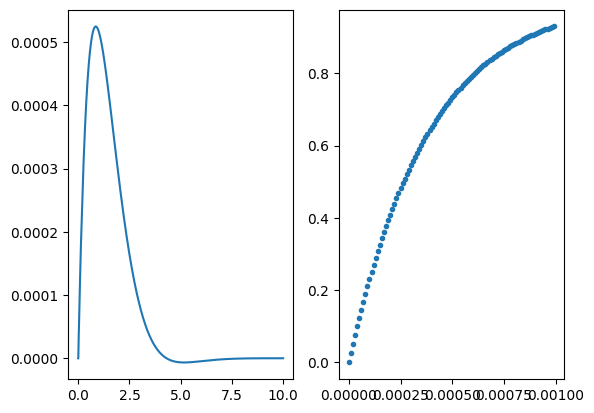

In [38]:
plt.figure()
T, yout, x = ct.step_response(closed_loop_system, T=T_sim, return_x=True, squeeze=True)
# plt.plot(T.T, yout[2,:])

controller_output = np.sum(yout*K.T, axis=0)

plt.subplot(121)
plt.plot(T, yout[0,:])
plt.subplot(122)
plt.plot(T[:100], controller_output[:100],'.')
plt.show()

In [39]:
noise = 2*np.pi/(2**14)
print(f'Effective rotary encoder resolution: {np.log2(1/(noise/(2*np.pi))):.3f} bits')
kf = KalmanFilter(n_inputs=1,
                  n_outputs=1,
                  n_states=4)
x=np.array([[0.005, 0, 1, 0]]).T
I = np.eye(A.shape[0])

kf.set_initial_state(x)
kf.set_F(A)
kf.set_B(B)
kf.set_H(C)
kf.set_Q(np.diag([0.000001, 0.00001, 0.1, 0.00001]))
kf.set_R(np.array([[noise**2]]))

Effective rotary encoder resolution: 14.000 bits


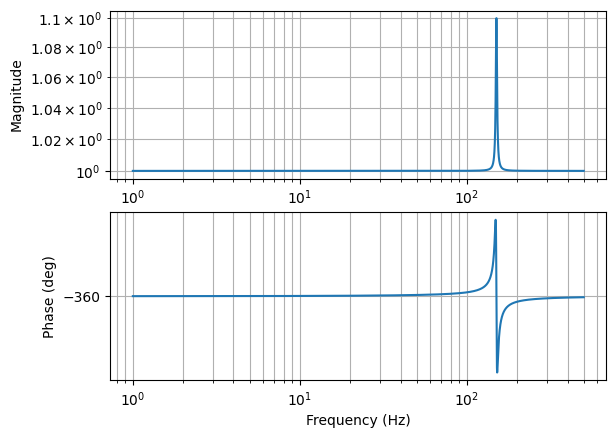

A = [[-1.88495559e+01  8.88264396e+02]
     [-1.00000000e+03  8.02295955e-15]]

B = [[-1.]
     [ 0.]]

C = [[-1.88495559e+00 -5.82195010e-13]]

D = [[1.]]



In [40]:
# model and add in some unmodeled resonances to the "true" system, but not the KF system
resonance = biquad_tf(150,3,1.1)
frequency_range = np.linspace(1, 500, 2500)*6.28  # Frequency range from 10Hz to 250Hz
mag, phase, omega = ct.bode_plot(resonance, omega=frequency_range, Hz=True)

# Show the plot
plt.show()
resonance = ct.tf2ss(resonance)
print(resonance)
res = System(resonance.A, resonance.B, resonance.C, resonance.D)

In [41]:

true_states = []
kf_states=[]
sensors=[]
u=np.array([[0.50]])
z_prev=0
pos = 0
pos_prev = 0
Ad = I+(A*dt)
Bd = B*dt

for i in range(int(5/dt)):
    if i == 25000:
        u = -u
    x = Ad@x + Bd @ u
    z = (C@x/noise).astype(np.int64)*noise # quantize encoder
    z = res.update(z,dt)  # Add in unmodeled resonance
    
    z_dot = (z-z_prev)/dt
    pos = pos+z_dot*dt*r
    pos_dot = (pos-pos_prev)/dt
    pos_prev = pos
    z_prev = z
    
    sensors.append([pos, pos_dot, z, z_dot])
    true_states.append(x)
    kf_states.append(kf.update(dt, z, u))

true_states=np.asarray(true_states)
kf_states=np.asarray(kf_states)
sensors = np.squeeze(np.asarray(sensors))

In [42]:
from scipy.signal import butter, lfilter
from scipy.signal import freqs

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

cutOff = 500*2*np.pi #cutoff frequency in rad/s
fs = (1/dt)*2*np.pi #sampling frequency in rad/s
order = 2 #order of filter

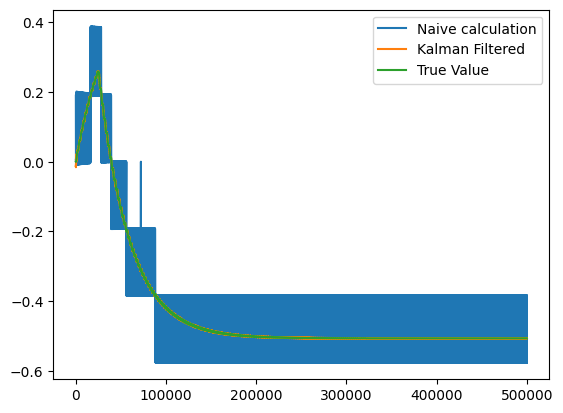

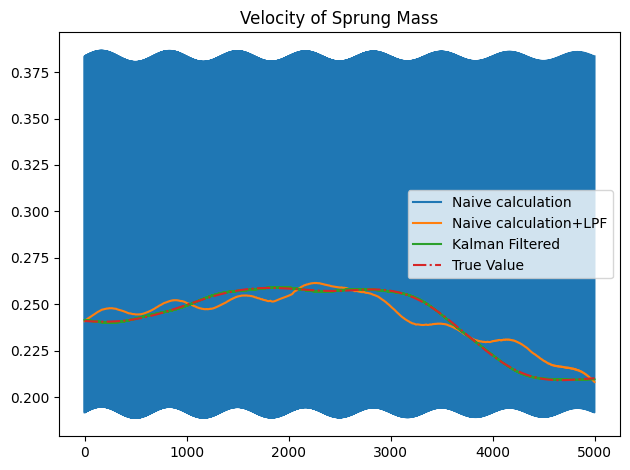

In [43]:
idx = 1
plt.figure()
plt.plot(sensors[100:,idx])
plt.plot(kf_states[100:,idx])
plt.plot(true_states[100:,idx])
plt.legend(['Naive calculation', 'Kalman Filtered', 'True Value'])


center = 25000
width = 5000
y = butter_lowpass_filter(sensors[:,idx], cutOff, fs, order)

plt.figure()
plt.title("Velocity of Sprung Mass")
plt.plot(sensors[int(center-width/2):int(center+width/2),idx])
plt.plot(y[int(center-width/2):int(center+width/2)])
plt.plot(kf_states[int(center-width/2):int(center+width/2),idx])
plt.plot(true_states[int(center-width/2):int(center+width/2),idx],'-.')
plt.legend(['Naive calculation','Naive calculation+LPF', 'Kalman Filtered', 'True Value'])
plt.tight_layout()
plt.show()
